In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F


from IPython.display import Image

# Introduction 

## What is  Semantic Segmentation
- 意思是在图像中的对象单元中分割有意义的对象或间隔 [来源](https://bskyvision.com/491)
<img src="../png/seg_example.png">   


- 换句话说，可以被认为是一种动作，其在图像的像素单元中预测对象的标签
<img src="../png/seg_example2.png"> 

- ECG心电图中有一个奇迹部分。 因此，ECG分段也是可能的[开源](https://sev.iseverance.com/heart/health_info/education/normal/view.asp?con_no=7111)
<img src="../png/ECG.jpg">

# Methods

## Model : U-Net

- 作为深度学习分割的代表模型，因其具有如下图所示的U形架构而得名。
- 它也可以被认为是一个层连接的自动编码器。
- 通过将特征图紧接在原始形状之后传递到最后一个 CNN 层，提高了原始形状的恢复性能。
- 全卷积网络应用于最后一层
<img src="../png/unet_arch.png">


- 本研究的模型结构引用了这篇论文"Deep learning for ECG segmentation"[link]
(https://arxiv.org/pdf/2001.04689.pdf)
<img src="../png/model.png">

## Dataset - LUDB
- Lobachevsky University Electrocardiography Database (LUDB) [link](https://physionet.org/content/ludb/1.0.0/)
- LUDB is an ECG signal database with marked boundaries and peaks of P, T waves and QRS complexes.
- The database consists of **200 10-second 12-lead ECG signal records** representing different morphologies of the ECG signal. 
- The ECGs were collected from healthy volunteers and patients of the Nizhny Novgorod City Hospital No 5 in 2017–2018. 
- The patients had various cardiovascular diseases while some of them had pacemakers. 
- The boundaries of P, T waves and QRS complexes were **manually annotated** by cardiologists for all 200 records. 

In [2]:
folder_path = '../physionet.org/files/ludb/1.0.0'
file_list = os.listdir(folder_path)
record_list = pd.read_csv(os.path.join(folder_path,'RECORDS')).values.ravel()

- MIMIC data 结构
- dat: 实际数据存储
- hea: 保存数据存储环境等信息
- atr,att... : DAT的各种注释文件

In [3]:
sorted(file_list)

['1.atr_avf',
 '1.atr_avl',
 '1.atr_avr',
 '1.atr_i',
 '1.atr_ii',
 '1.atr_iii',
 '1.atr_v1',
 '1.atr_v2',
 '1.atr_v3',
 '1.atr_v4',
 '1.atr_v5',
 '1.atr_v6',
 '1.dat',
 '1.hea',
 '10.atr_avf',
 '10.atr_avl',
 '10.atr_avr',
 '10.atr_i',
 '10.atr_ii',
 '10.atr_iii',
 '10.atr_v1',
 '10.atr_v2',
 '10.atr_v3',
 '10.atr_v4',
 '10.atr_v5',
 '10.atr_v6',
 '10.dat',
 '10.hea',
 '100.atr_avf',
 '100.atr_avl',
 '100.atr_avr',
 '100.atr_i',
 '100.atr_ii',
 '100.atr_iii',
 '100.atr_v1',
 '100.atr_v2',
 '100.atr_v3',
 '100.atr_v4',
 '100.atr_v5',
 '100.atr_v6',
 '100.dat',
 '100.hea',
 '101.atr_avf',
 '101.atr_avl',
 '101.atr_avr',
 '101.atr_i',
 '101.atr_ii',
 '101.atr_iii',
 '101.atr_v1',
 '101.atr_v2',
 '101.atr_v3',
 '101.atr_v4',
 '101.atr_v5',
 '101.atr_v6',
 '101.dat',
 '101.hea',
 '102.atr_avf',
 '102.atr_avl',
 '102.atr_avr',
 '102.atr_i',
 '102.atr_ii',
 '102.atr_iii',
 '102.atr_v1',
 '102.atr_v2',
 '102.atr_v3',
 '102.atr_v4',
 '102.atr_v5',
 '102.atr_v6',
 '102.dat',
 '102.hea',
 '103.a

In [4]:
pid = record_list[0]
# rdrecord : dat,hea 同时返回
record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
# annotation read 注解读出
atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

In [5]:
ECG_sample = record.p_signal[:,1] 
record.__dict__

{'record_name': '2',
 'n_sig': 12,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 64',
  '<sex>: M',
  '<diagnoses>:',
  'Electric axis of the heart: normal.',
  'Left atrial hypertrophy.',
  'Left ventricular hypertrophy.',
  'Non-specific repolarization abnormalities: posterior wall.'],
 'sig_name': ['i',
  'ii',
  'iii',
  'avr',
  'avl',
  'avf',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6'],
 'p_signal': array([[-161.99997231,   55.0045674 ,  216.99565556, ...,  -11.99084437,
          141.99567535,   -2.00726422],
        [-140.00083059,   52.00313193,  191.99918872, ...,    7.00399788,
          160.00726988,    7.00812077],
        [-192.0050943 ,   35.00587237,  226.99639995, ...,    0.        ,
          154.99757671,    5.00085655],
        ...,
        [ -17.00405606,  200.00326243,  216.99565556, ...,  151.98675404,
          135.00540581,  110.00154006],
        [ -36.99593472,  3

ECG lead II


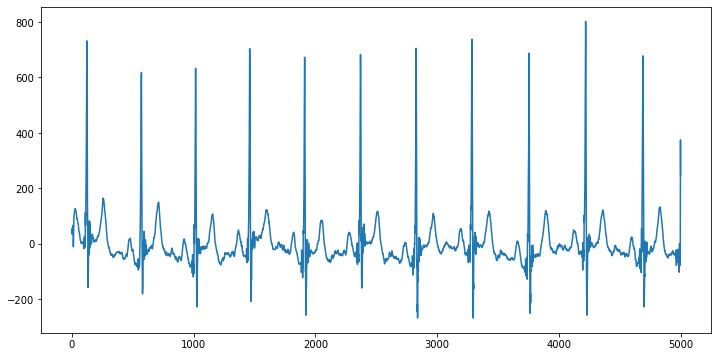

In [6]:
print("ECG lead II")
plt.figure(figsize=(12,6))
plt.plot(record.p_signal[:,1])

In [7]:
atr_ii.__dict__

{'record_name': '2',
 'extension': 'atr_ii',
 'sample': array([ 547,  569,  592,  659,  709,  750,  896,  920,  954,  995, 1015,
        1036, 1107, 1154, 1204, 1333, 1366, 1401, 1435, 1459, 1485, 1547,
        1599, 1640, 1793, 1820, 1852, 1886, 1910, 1929, 2007, 2052, 2091,
        2248, 2276, 2313, 2346, 2369, 2389, 2462, 2509, 2555, 2710, 2737,
        2769, 2799, 2826, 2847, 2931, 2968, 3008, 3168, 3192, 3226, 3261,
        3284, 3309, 3377, 3426, 3469, 3632, 3657, 3692, 3727, 3753, 3772,
        3843, 3890, 3932, 4096, 4121, 4161, 4195, 4218, 4236]),
 'symbol': ['(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',
  'p',
  ')',
  '(',
  'N',
  ')',
  '(',
  't',
  ')',
  '(',


In [8]:
target_Seg = 't' # p N t
position = np.where(np.array(atr_ii.symbol)==target_Seg)[0]
position_onset = position-1
position_offset = position+1

idx_onset= [atr_ii.sample[idx] for idx in position_onset]
idx_offset= [atr_ii.sample[idx] for idx in position_offset]
idx_all_set = [ [onset,offset] for (onset,offset) in zip(idx_onset,idx_offset)]

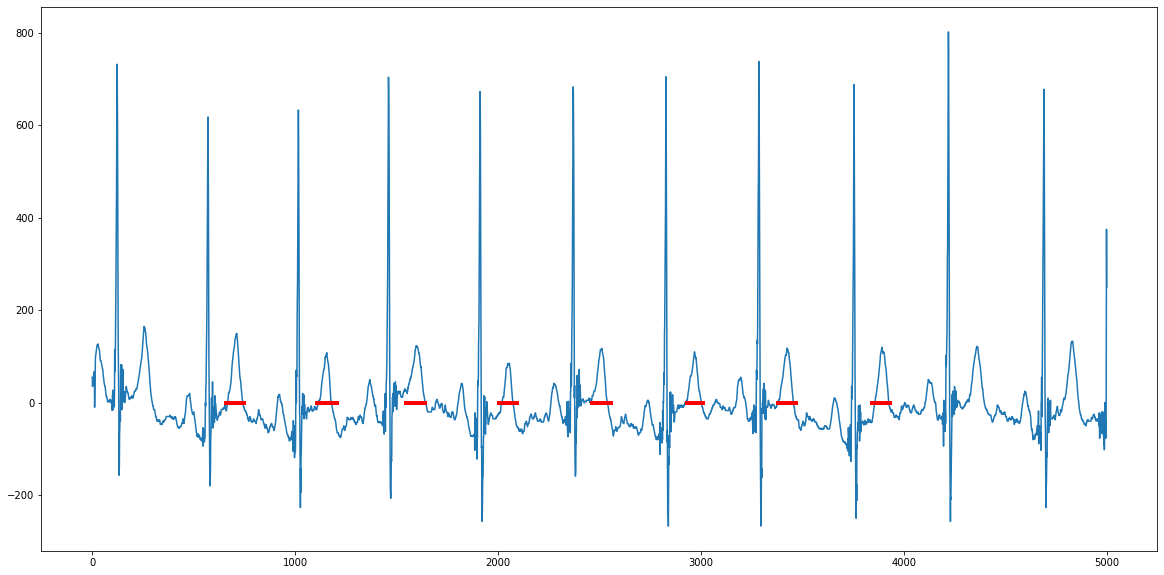

In [9]:
plt.figure(figsize=(20,10))
plt.plot(ECG_sample)
for points in idx_all_set:
    plt.plot(points,[0,0],c='r',linewidth=4)
plt.show()

### Data preprocessing
- 以 Sinus 单位修剪，P_onset 作为 600 个数据的起点，大约 1.2 (600/500) 秒

In [10]:
# wave_len = 600
# for number,pid in enumerate(record_list):
#     print('{}/{}'.format(number,len(record_list)))
#     record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
#     atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

#     atr_symbols = np.array(atr_ii.symbol)
#     atr_points = atr_ii.sample
#     lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
#     lead_II = record.p_signal[:,lead_II_idx]

#     p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
#     #以p 为起点剪切所有段。
#     for idx,p_onset in enumerate(p_onset_list):
#         p_idx = atr_points[p_onset]
#         lead_seg = lead_II[p_idx:p_idx+wave_len] ##进入df

#         include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]

#         # segments 存在于 symbol list
#         seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]
#         # 适用的symbol在seg ECG上的实际位置
#         seg_sybols_idx = include_symbols_idx - p_idx

#         unet_label_list = list()
#         unet_label_list.append(lead_seg)
#         for symbol in ['p','N','t']:
#             # seg_symbol list
#             PQRS_seg_symbols = np.where(seg_symbols==symbol)[0]

#             # seg_symbol list中的 p 起始位置
#             Onset_seg_symbols = PQRS_seg_symbols-1
#             Offset_seg_symbols = PQRS_seg_symbols+1

#             dummy = np.zeros(wave_len) #进入df
#             for onset,offset in zip(Onset_seg_symbols,Offset_seg_symbols[:len(Onset_seg_symbols)]):
#                 try:
#                     onset_idx = seg_sybols_idx[onset]
#                     offset_idx = seg_sybols_idx[offset]
#                     dummy[onset_idx:offset_idx] =1
#                 except IndexError:
#                     pass
#             unet_label_list.append(dummy)
        
#         if unet_label_list[-1].sum()!=0: #T 必须存在才能保存
#             seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
#             seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
#             unet_label_list.append(seg_remain)
            
#             #np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))

## Segmenst data load
- 有4个标签，包括P、QTS和T以及其余部分。

In [11]:
N=10

1234
10


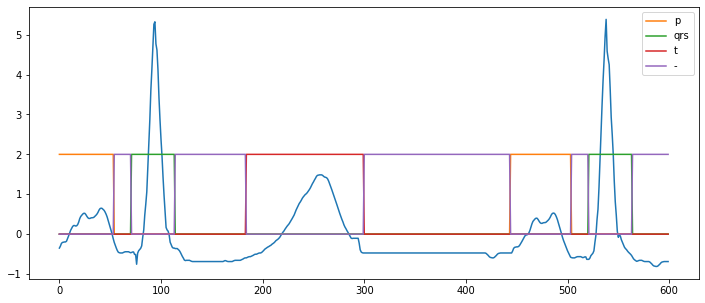

In [12]:
seg_flielist = os.listdir('../data/segments/')
print(len(seg_flielist))

seg_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in seg_flielist],columns=['pid','filename'])
seg_file_df = seg_file_df.sort_values(['pid','filename'])
seg_file_df['filepath'] = seg_file_df.filename.apply(lambda x : os.path.join('../data/segments',x))
seg_file_df = seg_file_df[seg_file_df.pid!='.ipynb']

seg = np.load(os.path.join('../data/segments',seg_file_df.filename.tolist()[N]))

plt.figure(figsize=(12,5))
plt.plot((seg[0]-np.mean(seg[0]))/np.std(seg[0]))
plt.plot((seg[1]*2),label='p')
plt.plot((seg[2]*2),label='qrs')
plt.plot((seg[3]*2),label='t')
plt.plot(seg[4]*2,label='-')
plt.legend()
print(N)
N+=1

In [13]:
#标签是什么格式
# P 的标签
seg[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Model Train

## dataset

In [14]:
class segment_dataset(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg_II = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
            mask_arr = seg[1:,:]
        except:
            print(self.filepath[item])
        
        return torch.from_numpy(ecg_II).unsqueeze(0),torch.from_numpy(mask_arr)


## Model Structure : U-net

In [15]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [16]:
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1)) ##concat
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1)) ##concat
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1)) ##concat
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

## Model Train

In [17]:
## hyper parameter
device = ['cpu','cuda:0'][1]
class_n = 4
total_epoch = 300

lr = 0.001
batch_size = 256

- 为每位患者分配 Train 和 Valid
- 心电图对每个患者都有不同的特征，所以如果患者混在一起就太容易了

In [18]:
pid_list = list(set(seg_file_df.pid.tolist()))
shuffle(pid_list)

tr_pid_list = pid_list[:int(len(pid_list)*(3/4))]
vd_pid_list = pid_list[int(len(pid_list)*(3/4)):]

tr_file_df = seg_file_df.query("pid in @tr_pid_list")
vd_file_df = seg_file_df.query("pid in @vd_pid_list")

tr_dataset = segment_dataset(tr_file_df)
vd_dataset = segment_dataset(vd_file_df)

tr_loader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader = DataLoader(vd_dataset,batch_size=batch_size)

- Model, optimizer, loss, schedular 生成

In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [20]:
#tr_output_list = list()
for epoch in range(total_epoch):
    model.train()
    train_loss = 0
    tr_output_list = list()
    for idx,(X,y) in enumerate(tr_loader):
        optim.zero_grad()
        
        y_pred = model(X.to(device))
        loss = loss_f(y_pred,y.to(device))
        
        loss.backward()
        optim.step()
        
        train_loss+=loss.cpu().item()/len(tr_loader)
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        tr_output_list.extend(list(out_pred))
        
    print("------------- {} epoch-------------".format(epoch))
    print("Train loss : {:.3f}".format(train_loss))
    
    vd_loss = 0
    model.eval()
    for idx,(X,y) in enumerate(vd_loader):

        y_pred = model(X.to(device))
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        
        loss = loss_f(y_pred,y.to(device))
        vd_loss+=loss.cpu().item()/len(vd_loader)
    print("Valid loss : {:.3f}".format(vd_loss))



------------- 0 epoch-------------
Train loss : 0.789
Valid loss : 0.700
------------- 1 epoch-------------
Train loss : 0.741
Valid loss : 0.704
------------- 2 epoch-------------
Train loss : 0.722
Valid loss : 0.706
------------- 3 epoch-------------
Train loss : 0.713
Valid loss : 0.706
------------- 4 epoch-------------
Train loss : 0.709
Valid loss : 0.704
------------- 5 epoch-------------
Train loss : 0.705
Valid loss : 0.701
------------- 6 epoch-------------
Train loss : 0.701
Valid loss : 0.698
------------- 7 epoch-------------
Train loss : 0.697
Valid loss : 0.693
------------- 8 epoch-------------
Train loss : 0.692
Valid loss : 0.688
------------- 9 epoch-------------
Train loss : 0.687
Valid loss : 0.684
------------- 10 epoch-------------
Train loss : 0.680
Valid loss : 0.682
------------- 11 epoch-------------
Train loss : 0.670
Valid loss : 0.680
------------- 12 epoch-------------
Train loss : 0.662
Valid loss : 0.676
------------- 13 epoch-------------
Train loss :

------------- 111 epoch-------------
Train loss : 0.566
Valid loss : 0.579
------------- 112 epoch-------------
Train loss : 0.566
Valid loss : 0.578
------------- 113 epoch-------------
Train loss : 0.566
Valid loss : 0.578
------------- 114 epoch-------------
Train loss : 0.565
Valid loss : 0.577
------------- 115 epoch-------------
Train loss : 0.565
Valid loss : 0.577
------------- 116 epoch-------------
Train loss : 0.564
Valid loss : 0.577
------------- 117 epoch-------------
Train loss : 0.564
Valid loss : 0.578
------------- 118 epoch-------------
Train loss : 0.564
Valid loss : 0.578
------------- 119 epoch-------------
Train loss : 0.564
Valid loss : 0.577
------------- 120 epoch-------------
Train loss : 0.564
Valid loss : 0.579
------------- 121 epoch-------------
Train loss : 0.564
Valid loss : 0.579
------------- 122 epoch-------------
Train loss : 0.563
Valid loss : 0.578
------------- 123 epoch-------------
Train loss : 0.563
Valid loss : 0.578
------------- 124 epoch--

------------- 221 epoch-------------
Train loss : 0.547
Valid loss : 0.576
------------- 222 epoch-------------
Train loss : 0.547
Valid loss : 0.575
------------- 223 epoch-------------
Train loss : 0.547
Valid loss : 0.576
------------- 224 epoch-------------
Train loss : 0.547
Valid loss : 0.576
------------- 225 epoch-------------
Train loss : 0.547
Valid loss : 0.576
------------- 226 epoch-------------
Train loss : 0.547
Valid loss : 0.575
------------- 227 epoch-------------
Train loss : 0.546
Valid loss : 0.574
------------- 228 epoch-------------
Train loss : 0.547
Valid loss : 0.578
------------- 229 epoch-------------
Train loss : 0.546
Valid loss : 0.574
------------- 230 epoch-------------
Train loss : 0.546
Valid loss : 0.576
------------- 231 epoch-------------
Train loss : 0.546
Valid loss : 0.575
------------- 232 epoch-------------
Train loss : 0.546
Valid loss : 0.574
------------- 233 epoch-------------
Train loss : 0.546
Valid loss : 0.573
------------- 234 epoch--

In [21]:
#save model
torch.save(model, '../data/model.pt') 

# Results

In [22]:
model = torch.load('../data/model.pt',map_location=device)

In [24]:
# 后处理，窗口内出现最多的标签为当前标签
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number 奇数
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

In [25]:
print('MY ACC')
p_dict = [0] * 4
r_dict = [0] * 4
p_sum_dict = [0] * 4
r_sum_dict = [0] * 4
model.eval()

for idx,(X,y) in enumerate(vd_loader):

    y_pred = model(X.to(device))
    out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
    
    # 后处理
    y_pred =np.array([ output_sliding_voting(i,9) for i in out_pred])
    y = np.argmax(y.numpy(), axis=1)
    for i in range(len(r_dict)):
        r_dict[i] += np.sum((y == y_pred) & (y == i))
        p_dict[i] += np.sum((y == y_pred) & (y_pred == i))
        r_sum_dict[i] += np.sum(y == i)
        p_sum_dict[i] += np.sum(y_pred == i)

acc = np.sum(r_dict) / np.sum(r_sum_dict)
print("All-acc", acc)
keys = ['bg', 'p', 'r', 't']
for i in range(len(r_dict)):
    pi = np.sum(p_dict[i]) / np.sum(p_sum_dict[i])
    print("%s-p" % keys[i], np.sum(p_dict[i]), '/', np.sum(p_sum_dict[i]), "=", pi)
    ri = np.sum(r_dict[i]) / np.sum(r_sum_dict[i])
    print("*%s-r" % keys[i], np.sum(r_dict[i]), '/', np.sum(r_sum_dict[i]), "=", ri)


MY ACC


C:\Users\bear\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


All-acc 0.9144736842105263
bg-p 29913 / 33281 = 0.8988011177548751
*bg-r 29913 / 31973 = 0.9355706377255809
p-p 18007 / 20390 = 0.8831289847964688
*p-r 18007 / 20405 = 0.8824797843665768
r-p 27104 / 30380 = 0.8921658986175115
*r-r 27104 / 29219 = 0.9276155925938602
t-p 91776 / 98349 = 0.9331665802397584
*t-r 91776 / 100803 = 0.9104490937769709


In [26]:
vd_ecg_list = list()
vd_label_list = list()
vd_output_list = list()

model.eval()

for idx,(X,y) in enumerate(vd_loader):

    y_pred = model(X.to(device))
    out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
    
    vd_output_list.extend(list(out_pred))
    vd_ecg_list.extend(list(X.cpu().detach().numpy().squeeze(1)))
    vd_label_list.extend(list(y.cpu().detach().numpy()))
    break

In [27]:
sample_n = 0

0


C:\Users\bear\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


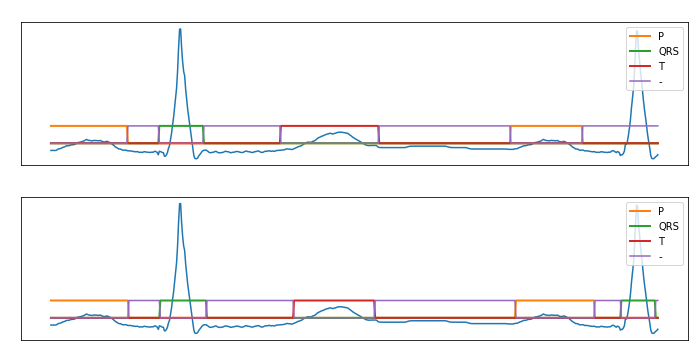

In [28]:
print(sample_n)
ecg = vd_ecg_list[sample_n]
label = vd_label_list[sample_n]

output = vd_output_list[sample_n]
output = output_sliding_voting(output,9)

p = (output == 0)
N = (output == 1)
t = (output == 2)
r = (output == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True boundary",color='white')
    axes[0].plot(ecg)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")
sample_n+=10

## External Validation

<img src="../png/MUSE1.png">
<img src="../png/MUSE2.png">
<img src="../png/MUSE3.png">
<img src="../png/MUSE4.png">
<img src="../png/MUSE5.png">

# Discussion
- 来自 200 名患者的 10 秒数据，每位患者约 7 个分段（segmentation）
- 经证实，即使有 1400 条数据，性能也相当不错。
- 未能客观评价
- 猜测训练数据无条件以P onset为起点，在sada中表现异常
- 增强，如果您使用不同的起点进行训练，您可以期望在开始时获得一个健壮的模型。